<h1> Data Science - Finding the best candy to bring to the market. </h1>

A market study was conducted. 8,371 people voted on whether they like a candy or not.
On average, each person rated 32 candies, giving a total of around 269,000 ratings.

A supermarket wants to bring out  new candy, and asked what characteristics the candy should have. We will analyse this information for insights into what people like.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import os

In [27]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [28]:
data = pd.read_csv("../input/the-ultimate-halloween-candy-power-ranking/candy-data.csv")

In [29]:
# check for missing values
print ("Data Missing Values\n")
print (data.isnull().sum())

Data Missing Values

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64


No data cleanup is required.

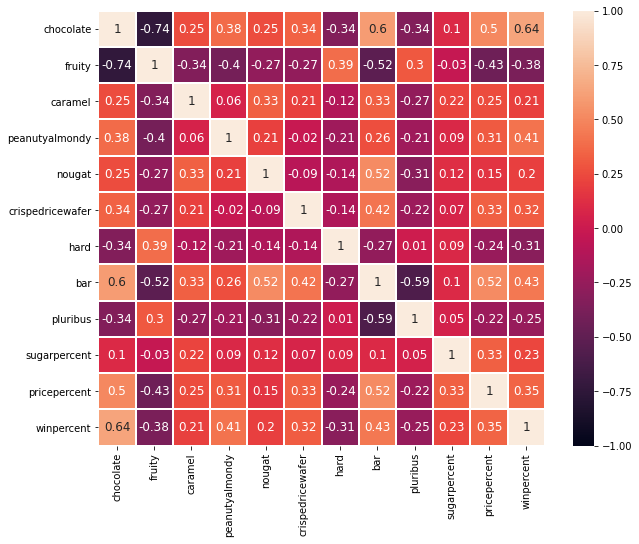

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(round(data.corr(), 2), annot=True, vmin=-1, vmax = +1, linewidths=0.1, annot_kws={"fontsize":12})
plt.show()

^ Correlation Heatmap

Question: what is the relationship between winpercent and other variables?

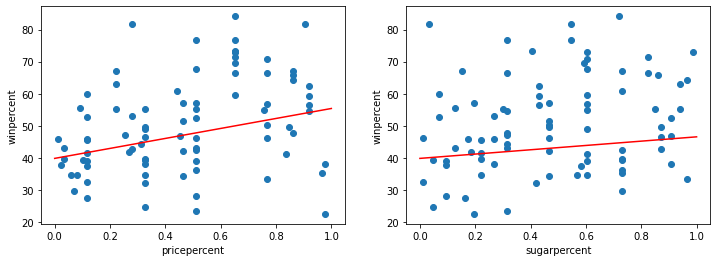

Linear regression results:
------------
                   coef
sugarpercent   6.731072
pricepercent  15.586494

intercept: 39.79
----------
explained_variance:  0.1342
mean_squared_log_error:  0.0776
r2:  0.1342
MAE:  10.7866
MSE:  185.2587
RMSE:  13.611


In [31]:
# linear regression y = winpercent, x = sugarpercent, pricepercent
y = data["winpercent"]
X = data[["sugarpercent", "pricepercent"]]

linear_regression_model = LinearRegression(fit_intercept=True)
linear_regression_model.fit(X, y)

y_pred = linear_regression_model.predict(X)
score = linear_regression_model.score(X, y)
mse = mean_squared_error(y, y_pred)

coeffs = pd.DataFrame(linear_regression_model.coef_, X.columns, columns=['coef'])
intercept  = linear_regression_model.intercept_

# graphics
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(x=data["pricepercent"], y=data["winpercent"])
## plot line
x = np.linspace(0, 1)
y1 = coeffs.values[1]*x + intercept
plt.plot(x, y1, "r-")
plt.xlabel("pricepercent")
plt.ylabel("winpercent")

plt.subplot(1, 2, 2)
plt.scatter(x=data["sugarpercent"], y=data["winpercent"])
y2 = coeffs.values[0]*x + intercept
plt.plot(x, y2, "r-")
plt.xlabel("sugarpercent")
plt.ylabel("winpercent")

plt.show()

## summarise results
print (f'Linear regression results:\n------------')
print (f'{coeffs}')
print (f'\nintercept: {round (intercept, 2)}')
print ("----------")
regression_results(y, y_pred)

<p>No significant correlation between winpercent and sugarpercent, and winpercent and pricepercent. Can ignore sugarpercent and pricepercent. </p>

In [32]:
# linear regression for categories
y = data["winpercent"]
X = data.drop(["winpercent", "competitorname", "sugarpercent", "pricepercent"],axis=1)

linear_regression_model = LinearRegression(fit_intercept=True)
linear_regression_model.fit(X, y)

y_pred = linear_regression_model.predict(X)
score = linear_regression_model.score(X, y)
mse = mean_squared_error(y, y_pred)

coeffs = pd.DataFrame(linear_regression_model.coef_, X.columns, columns=['coef']).sort_values('coef', ascending = False)
intercept  = linear_regression_model.intercept_

## summarise results
print (f'Linear regression results:\n------------')
print (f'{coeffs}')
print (f'\nintercept: {round (intercept, 2)}')
print ("----------")
regression_results(y, y_pred)

Linear regression results:
------------
                       coef
chocolate         19.905795
fruity            10.267732
peanutyalmondy    10.141017
crispedricewafer   8.991549
caramel            3.384282
nougat             2.416252
pluribus          -0.159917
bar               -0.721966
hard              -4.872560

intercept: 35.02
----------
explained_variance:  0.5148
mean_squared_log_error:  0.0469
r2:  0.5148
MAE:  8.121
MSE:  103.8138
RMSE:  10.1889


Linear regression was performed on all features, disregarding sugar and price.

Key insights:
* Chocolate raises winpercent by 20% on average.
* Peanuts, caramel, nougat, etc have a positive effect, so composite candy should have higher rating.
* Chocolate preferred over fruit (they are mutually exclusive).

Form: 
* bar is preferred over hard material (like lollypop).
* Pluribus has highest rating, but less important than containing mixtures of things, so bar is preferred.

Result… best candy is

Chocolate in bar form, maybe containing
peanuts/almonds, crisped rice/wafer, caramel, nougat

In [33]:
'''
PERFECT CANDY (BASED ON ABOVE REGRESSION MODEL)

fruit and chocolate are mutually exclusive. 
Chocolate has a bigger effect on winpercent

main material: 
+ chocolate

additional:
+ peanuts and almonds
+ crispedricewafer
+ caramel
+ nougat

form: 
+ bar

'''
perfect_candy_score = intercept+coeffs.values[0]+coeffs.values[2]+coeffs.values[3]+\
coeffs.values[4]+coeffs.values[5]+coeffs.values[7]

print (f'Perfect candy score: {round(perfect_candy_score[0], 1)}%')

Perfect candy score: 79.1%


In [34]:
## exploring structure of data

useful_columns = ["chocolate", "fruity", "caramel", "peanutyalmondy", "nougat", "crispedricewafer", "hard", "bar", "pluribus"]

data_sorted = data.sort_values('winpercent', ascending = True)
data_length = len(data_sorted)
divisions = 4
segments = []

segment_values = []
final_values_dict = {}

for i in range (0, divisions):
    #segments.append (data_sorted[(i*data_length//divisions):((i+1)*data_length//divisions)])
    temp_data = data_sorted[(i*data_length//divisions):((i+1)*data_length//divisions)]
    temp_dict = {}
    for col in useful_columns:
        temp_dict[col] = np.sum(temp_data[col])
    segment_values.append (temp_dict)

x_values = [25, 50, 75, 100]

for col in useful_columns:
    value_array = []
    for val in segment_values:
        value_array.append(val[col])
    final_values_dict[col] = value_array

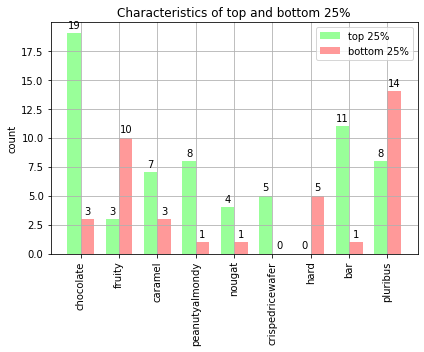

In [35]:
# top 25 and bottom 25 %
top25 = [float(segment_values[3][k]) for k in useful_columns]
bottom25 = [float(segment_values[0][k]) for k in useful_columns]

x = np.arange(len(useful_columns))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.bar(x - width/2, top25, width, label='top 25%', color="#99ff99")
rects2 = ax.bar(x + width/2, bottom25, width, label='bottom 25%', color="#ff9999")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Characteristics of top and bottom 25%')
ax.set_xticks(x)
ax.set_xticklabels(useful_columns)
plt.xticks(rotation=90)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.grid(True)

plt.show()

Frequency of different characteristics of best and worst performing candies.

Key Insights:
* Chocolate appears more often in best performing candy.
* Fruit more often in disliked candy, so avoid.
* Best performing candy takes mostly bar form.
* Hard form appears in bottom candy more often, so avoid.

<p> Find whether pure chocolate is preferred over mixed chocolate. </p

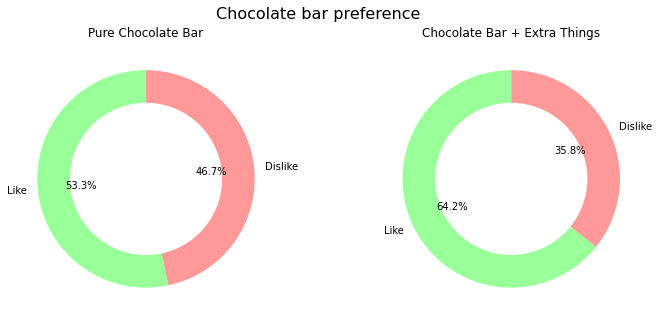

In [36]:
# pure chocolate bar vs chocolate with something

## calculations
pure_choc_bar = data[(data["chocolate"] == 1) & (data["bar"] == 1) & (data["caramel"] == 0) & 
     (data["peanutyalmondy"] == 0) & (data["nougat"] == 0) & (data["crispedricewafer"] == 0)]

unpure_choc_bar = data[(data["chocolate"] == 1) & (data["bar"] == 1) & ((data["caramel"] == 1) | 
     (data["peanutyalmondy"] == 1) | (data["nougat"] == 1) | (data["crispedricewafer"] == 1))]

pure_choc_bar_percent = round(np.sum(pure_choc_bar["winpercent"])/len(pure_choc_bar), 2)
unpure_choc_bar_percent = round(np.sum(unpure_choc_bar["winpercent"])/len(unpure_choc_bar), 2)


# pie charts (graphics)
y_pure = np.array([pure_choc_bar_percent, 100-pure_choc_bar_percent])
y_unpure = np.array([unpure_choc_bar_percent, 100-unpure_choc_bar_percent])

pie_labels = ["Like", "Dislike"]

fig = plt.figure(figsize=(12,5))
fig.suptitle('Chocolate bar preference', fontsize=16)
plt.subplot(1, 2, 1)

plt.title('Pure Chocolate Bar')
plt.pie(y_pure, labels = pie_labels, startangle = 90, colors=["#99ff99", "#ff9999"], autopct='%1.1f%%')
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.subplot(1, 2, 2)
plt.title('Chocolate Bar + Extra Things')
plt.pie(y_unpure, labels = pie_labels, startangle = 90, colors=["#99ff99", "#ff9999"], autopct='%1.1f%%')
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show() 

The clear winner is chocolate with extra things. Average rating of mixed chocolate was 10% higher than
pure chocolate. 

Next: Find best chocolate mix.

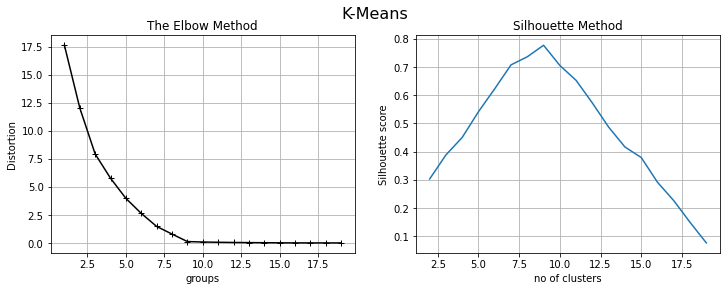

In [37]:
# K means clustering to find main combinations
k_labels = ["caramel", "peanutyalmondy", "nougat", "crispedricewafer", "winpercent"]

df = data.drop(["competitorname", "sugarpercent", "pricepercent"],axis=1)

df = df[(df["chocolate"] == 1) & (df["bar"] == 1) & (df["fruity"] == 0)]
df = df[k_labels]
df["winpercent"] = df["winpercent"]/100  # scale to fit categorical data distances

data_KMeans = df

## unique candy classes
unique_candy_classes = len(data_KMeans.drop_duplicates())

## elbow method
distortions = []
K = range(1,unique_candy_classes)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_KMeans)
    distortions.append(kmeanModel.inertia_)

## silhouette method
range_n_clusters = range(2,unique_candy_classes)
scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df)
    centers = clusterer.cluster_centers_

    score = silhouette_score(df, preds)
    scores.append(score)

# graphics
fig = plt.figure(figsize=(12,4))
fig.suptitle('K-Means', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('The Elbow Method')
plt.plot(K, distortions, '+-', color="black")
plt.xlabel('groups'); plt.ylabel('Distortion'); plt.grid(True)


plt.subplot(1, 2, 2)
plt.title('Silhouette Method')
plt.plot(range_n_clusters, scores)
plt.grid(True)
plt.xlabel("no of clusters")
plt.ylabel("Silhouette score")

plt.show()

Finding number of clusters in data.
Optimum number of clusters: 9

In [38]:
kmeanModel = KMeans(n_clusters=9)
kmeanModel.fit(data_KMeans)

df = pd.DataFrame (data=np.round(kmeanModel.cluster_centers_, 3), columns=k_labels)
df["winpercent"] = df["winpercent"]*100  # unscale winpercent to range 0-100
print ("Main Candy subgroups\n")
print (df.sort_values("winpercent", ascending=False))

Main Candy subgroups

   caramel  peanutyalmondy  nougat  crispedricewafer  winpercent
5      1.0             0.0     0.0               1.0        74.3
0      0.0             0.0     0.0               1.0        68.5
1      1.0             0.0     1.0               0.0        67.0
7      1.0             1.0     1.0               0.0        66.8
8      1.0             0.0     0.0               0.0        64.4
3      1.0             1.0     0.0               1.0        59.5
2      0.0             1.0     0.0               0.0        58.5
4      0.0             0.0     0.0               0.0        53.3
6      0.0             0.0     1.0               0.0        53.3


Best candy according to K-Means analysis:
* Chocolate (Bar)
* Caramel
* Crispedricewafer


In [39]:
def cbcaw(array): # chocolate_bar_composite_average_winpercent
    try:
        selection = data[(data["chocolate"] == 1) & (data["bar"] == 1) & (data["caramel"] == array[0]) & 
         (data["peanutyalmondy"] == array[1]) & (data["nougat"] == array[2]) & 
                         (data["crispedricewafer"] == array[3])]
    except:
        return np.nan
    else:
        return round(np.sum(selection["winpercent"])/len(selection), 2)
    
def interpret_structure(array):
    structure = []
    if array[0] == 1:
        structure.append("caramel")
    if array[1] == 1:
        structure.append("peanutyalmondy")
    if array[2] == 1:
        structure.append("nougat")
    if array[3] == 1:
        structure.append("crispedricewafer")
    return structure

def evaluate_structure(array):
    print (f'Structure of candy: {interpret_structure(array)}')
    print (f'Average win percent of combination: {cbcaw(array)}%')

In [40]:
import itertools
lst = list(itertools.product([0, 1], repeat=4))
avg_winpercent = []

for combo in lst:
    avg_winpercent.append(cbcaw(combo))

max_index = np.nanargmax(avg_winpercent)
max_avg_winpercent = np.nanmax(avg_winpercent)

print (f'Structure of best candy: {interpret_structure(lst[max_index])}')
print (f'Average win percent of combination: {max_avg_winpercent}%')

Structure of best candy: ['caramel', 'crispedricewafer']
Average win percent of combination: 74.31%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: in

Calculated the average winpercent of all existing combinations within the dataset.
Highest average winpercent belongs to
* Chocolate bar
* Caramel
* Crisped Rice / Wafer

Average winpercent: 74.3%

Result agrees with K Means analysis.

In [41]:
# top 5 best performing candy (according to reported winpercent)
data.sort_values('winpercent', ascending = False)[0:5]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


^ Top 5 candies according to winpercent

Data disclaimers and validity of results:

* Data was collected by asking people whether or not they like a candy.
* Not representative of whether they will actually purchase the candy in store.
* No link between winpercent, sugarpercent and pricepercent was found. Maybe in a real life situation, customers will pay attention to price and sugar content more.
* Different demographics shop differently. Some health conscious customers might pay more for a candy to contain less sugar, whereas other customers might go for the cheapest candy, irrespective of sugar or composition.

Executive Summary

We analysed a dataset to find what characteristics make up the most liked candy. The most liked characteristics found are:

* Chocolate
* Bar
* Caramel
* Crisped Rice / Wafer
Next steps:
1. * Investigate shopping patterns of customers
   * Are they health conscious?
   * Do they buy what they like, or buy cheaper options?
2. Combine findings of this study with findings from step 1, to design candy which people will like and will buy
3. Bring new candy to the market.